In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from xgboost import XGBRegressor

In [2]:
driver = 'postgres'
username = 'ds4a'
password = 'ds4A-7eaM79'
host = 'ds4a.cm1dcdf7pnnv.us-east-2.rds.amazonaws.com'
port = 5432
database = 'team_79'

connection_string = f'{driver}://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_string, encoding='utf8')

In [3]:
tablas = [
    'violencia_intrafamiliar',
    'homicidios',
    'hurto_automotores',
    'hurto_motocicletas',
    'del_sexuales',
    'hurto_personas'
]

query = '''
SELECT
    FLOOR(row_num/ 2) as week,
    (max(weekly) + interval '14 day')::date as ds,
    sum(total_count) as num_cases
FROM (
    SELECT
        date_trunc('week', fecha) AS weekly,
        row_number() over (order by date_trunc('week', fecha)) - 1 AS row_num,
        COUNT(*)  total_count
    FROM {}
    WHERE fecha >= '2015-12-21'
    AND municipio like 'BOGO%%'
    GROUP BY 1
    ORDER BY 1
) t
GROUP BY 1
ORDER BY 1
''';

In [4]:
data = {i:pd.read_sql(query.format(i), engine) for i in tablas}

In [5]:
def rolling(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def mape(true, preds):
    return np.mean(np.abs(true - preds)/np.abs(true))

In [6]:
def get_data(window_type='W', window_size=5):
    resampled_data = {}
    for i in data.keys():
        data[i].ds = pd.to_datetime(data[i].ds)
        resampled_data[i] = data[i].set_index('ds')['num_cases']
    
    X_train = {}
    X_test = {}

    y_train = {}
    y_test = {}

    for i in tablas:
        X = rolling(resampled_data[i].to_numpy(), window_size)
        y = X[1:,-1]
        X = X[:-1, :]
        
        X_train[i], X_test[i] = X[0:int(X.shape[0]*0.8),:], X[int(X.shape[0]*0.8):,:]
        y_train[i], y_test[i] = y[0:int(y.shape[0]*0.8)], y[int(y.shape[0]*0.8):]

        temp = np.arange(X_train[i].shape[0])
        np.random.seed(0)

        np.random.shuffle(temp)
        X_train[i] = X_train[i][temp, :]
        y_train[i] = y_train[i][temp]
        
    return (X_train, X_test, y_train, y_test, resampled_data)

## XGBoost Models

In [9]:
model = {}
X_train, X_test, y_train, y_test, _ = get_data(window_type='W', window_size=4)

for i in tablas:
    model[i] = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.005, n_jobs=-1)
    model[i].fit(
        X_train[i],
        y_train[i],
        eval_set=[(X_test[i], y_test[i])],
        eval_metric='mae',
        early_stopping_rounds=100,
        verbose=0
    )

print('---------------------------------------------------')
for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(skm.mean_absolute_error(y_test[i], model[i].predict(X_test[i]))),
        '  ',
        '{:.2f}'.format(skm.mean_absolute_error(y_test[i], [y_test[i].mean()]*y_test[i].shape[0])),
    )

print()

for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(skm.mean_squared_error(y_test[i], model[i].predict(X_test[i]))),
        '  ',
        '{:.2f}'.format(skm.mean_squared_error(y_test[i], [y_test[i].mean()]*y_test[i].shape[0])),
    )

print()

for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(mape(y_test[i], model[i].predict(X_test[i]))),
        '  ',
        '{:.2f}'.format(mape(y_test[i], [y_test[i].mean()]*y_test[i].shape[0])),
    )

print()
for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(mape(y_test[i], model[i].predict(X_test[i]))),
        '  ',
        '{:.2f}'.format(mape(y_test[i], X_test[i][:, -1])),
    )

---------------------------------------------------
violencia_intrafamiliar	 268.05    274.46
homicidios		 7.61    7.66
hurto_automotores	 18.31    19.02
hurto_motocicletas	 25.42    22.35
del_sexuales		 42.48    43.84
hurto_personas		 982.90    476.08

violencia_intrafamiliar	 131810.49    160576.50
homicidios		 127.01    123.42
hurto_automotores	 677.61    913.04
hurto_motocicletas	 1503.35    1359.08
del_sexuales		 4374.76    4659.09
hurto_personas		 1387554.80    802413.17

violencia_intrafamiliar	 1.80    2.16
homicidios		 0.50    0.47
hurto_automotores	 0.54    0.67
hurto_motocicletas	 0.85    0.84
del_sexuales		 2.25    2.24
hurto_personas		 0.29    0.23

violencia_intrafamiliar	 1.80    0.75
homicidios		 0.50    0.74
hurto_automotores	 0.54    0.54
hurto_motocicletas	 0.85    0.78
del_sexuales		 2.25    0.72
hurto_personas		 0.29    0.24


## FB prophet

In [10]:
from fbprophet import Prophet

In [12]:
fb_model = {}
fb_train = {}
fb_test = {}

_, _, _, _, resampled_data = get_data()
for i in tablas:
    fb_model[i] = Prophet(weekly_seasonality=True, daily_seasonality=True)
    temp = resampled_data[i].rename_axis('ds').reset_index(name='y')

    fb_train[i], fb_test[i] = temp.iloc[:int(temp.shape[0]*0.8)].copy(), temp.iloc[int(temp.shape[0]*0.8):].copy()
    fb_model[i].fit(fb_train[i])


print('--------------------------------------')
for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(skm.mean_absolute_error(fb_test[i]['y'].to_numpy(), fb_model[i].predict(fb_test[i][['ds']]).yhat.to_numpy())),
        '  ',
        '{:.2f}'.format(skm.mean_absolute_error(fb_test[i]['y'].to_numpy(), [fb_test[i]['y'].mean()]*fb_test[i]['y'].shape[0])),
    )

print()

for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(skm.mean_squared_error(fb_test[i]['y'].to_numpy(), fb_model[i].predict(fb_test[i][['ds']]).yhat.to_numpy())),
        '  ',
        '{:.2f}'.format(skm.mean_squared_error(fb_test[i]['y'].to_numpy(), [fb_test[i]['y'].mean()]*fb_test[i]['y'].shape[0])),
    )

print()
for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(mape(fb_test[i]['y'].to_numpy(), fb_model[i].predict(fb_test[i][['ds']]).yhat.to_numpy())),
        '  ',
        '{:.2f}'.format(mape(fb_test[i]['y'].to_numpy(), [fb_test[i]['y'].mean()]*fb_test[i]['y'].shape[0])),
    )

print()
for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(mape(fb_test[i]['y'].to_numpy(), fb_model[i].predict(fb_test[i][['ds']]).yhat.to_numpy())),
            '  ',
        '{:.2f}'.format(mape(fb_test[i]['y'].to_numpy(), fb_test[i]['y'][:])),
    )

--------------------------------------
violencia_intrafamiliar	 275.56    271.42
homicidios		 8.30    7.59
hurto_automotores	 24.69    18.41
hurto_motocicletas	 25.54    22.62
del_sexuales		 43.31    42.44
hurto_personas		 581.73    466.36

violencia_intrafamiliar	 108628.92    154281.90
homicidios		 126.75    119.79
hurto_automotores	 1020.48    874.98
hurto_motocicletas	 1385.61    1345.51
del_sexuales		 5240.72    4469.51
hurto_personas		 957194.80    775972.27

violencia_intrafamiliar	 1.23    2.06
homicidios		 0.49    0.46
hurto_automotores	 0.62    0.64
hurto_motocicletas	 0.81    0.81
del_sexuales		 2.61    2.15
hurto_personas		 0.25    0.22

violencia_intrafamiliar	 1.23    0.00
homicidios		 0.49    0.00
hurto_automotores	 0.62    0.00
hurto_motocicletas	 0.81    0.00
del_sexuales		 2.61    0.00
hurto_personas		 0.25    0.00


In [13]:
import joblib as jl
from datetime import datetime
# jl.dump('./models/fb_model[i]


# exporting models
model_final = {}
model_final['dom_viol'] = fb_model['violencia_intrafamiliar']
model_final['murder'] = fb_model['homicidios']
model_final['sex_off'] = model['del_sexuales']
model_final['robbery'] = model['hurto_personas']

jl.dump(model_final, 'time_series_models.pkl')

['time_series_models.pkl']

## Example

In [38]:
crime = 'homicidios'

import seaborn as sns

# fig, ax = plt.figure(figsize=(16, 9))
preds_XGboost = model[crime].predict(X_test[crime])
preds_Prophet = fb_model[crime].predict(fb_test[crime][['ds']])

Text(0.5, 1.0, 'Murders')

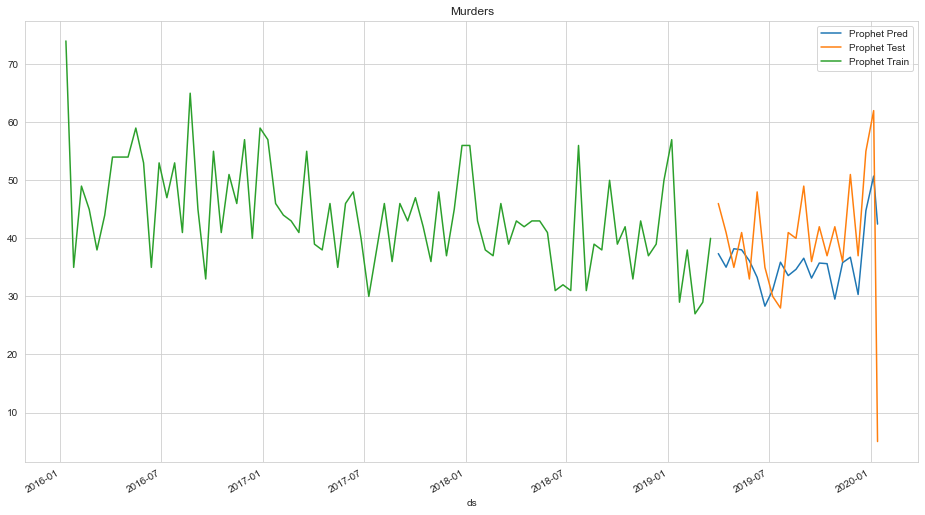

In [39]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16,9))
preds_Prophet.set_index('ds').yhat.plot(ax=ax, label='Prophet Pred')
fb_test[crime].set_index('ds').y.plot(ax=ax, label='Prophet Test')
fb_train[crime].set_index('ds').y.plot(ax=ax, label='Prophet Train')

ax.legend()
ax.set_title('Murders')